# Pets of Seattle
The Seattle government has publicly available pet license information. Learn more at https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Alternatively, just download it and read the CSV file locally
license_file = "https://data.seattle.gov/api/views/jguv-t9rb/rows.csv?accessType=DOWNLOAD"

In [3]:
pets = pd.read_csv(license_file)
pets = pets.dropna(subset=["ZIP Code"])
pets = pets.fillna(
    {
        "Secondary Breed": "",
    },
)
pets = pets[pets["ZIP Code"].str.match("^\d{5}$")]  # Only use rows that contain a 5-digit ZIP Code
pets

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,August 12 2016,579527,Mitzi,Cat,Domestic Longhair,,98116
1,October 09 2016,434583,Kasa,Cat,LaPerm,,98126
2,October 11 2016,832624,Kitty,Cat,Siamese,,98103
3,October 22 2016,833657,Zoey,Cat,Siamese,,98118
4,January 05 2017,898869,NaN,Cat,Domestic Shorthair,,98103
5,February 09 2017,79268,Lumpy,Cat,Domestic Medium Hair,,98117
6,February 28 2017,73961,Oliver,Cat,LaPerm,,98112
7,March 10 2017,129273,Mitsu,Cat,LaPerm,,98118
8,July 06 2017,353219,Murlyn,Cat,LaPerm,,98118
9,July 25 2017,272597,Abby,Cat,Maine Coon,,98199


Species
Dog     35291
Cat     17812
Goat       38
Pig         5
Name: Species, dtype: int64

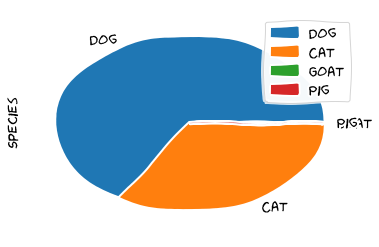

In [20]:
pet_species = pets.groupby("Species").Species.count().sort_values(ascending=False)
with plt.xkcd():
    pet_species.plot.pie(legend=True)
pet_species

# Seattle has livestock?
Color me intrigued - what kind of livestock do we have?

In [5]:
pets[pets.Species == "Livestock"]

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code


![](http://potbellypigs.com/wordpress1/wp-content/uploads/2015/03/pig17.jpg)
Cute!

Image credit of http://potbellypigs.com/wordpress1/

# Seattlites are dog afficionados
apparently

In [6]:
dogs = pets[pets.Species == "Dog"]
dogs

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
28,October 15 2016,835087,Mina,Dog,Beagle,,98103
30,October 19 2016,827747,Abigail,Dog,Bloodhound,,98117
31,November 08 2016,30008,Pebbles,Dog,Pug,,98125
32,November 15 2016,26271,Sunny,Dog,Whippet,,98115
33,December 08 2016,958444,MoMo,Dog,"Retriever, Labrador",Mix,98144
34,December 14 2016,958274,Leela,Dog,Shih Tzu,,98115
35,April 10 2017,142703,Komatsu,Dog,Pug,,98117
36,April 28 2017,215097,Sophia,Dog,"Terrier, Yorkshire",,98122
37,August 28 2017,584633,Lily,Dog,"Retriever, Labrador",,98122
38,September 20 2017,718096,Gypsy,Dog,"Terrier, Cairn",,98117


In [7]:
dog_breeds = dogs.groupby("Primary Breed")["Primary Breed"].count().sort_values(ascending=False)

top_n = 10
top_dog_breeds = dog_breeds[:top_n]

Primary Breed
Retriever, Labrador           5050
Retriever, Golden             1885
Chihuahua, Short Coat         1858
German Shepherd               1015
Terrier                        989
Australian Shepherd            929
Border Collie                  829
Poodle, Miniature              801
Terrier, American Pit Bull     698
Shih Tzu                       650
Name: Primary Breed, dtype: int64

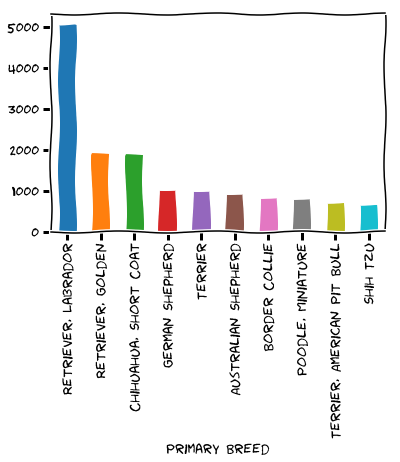

In [8]:
with plt.xkcd():
    top_dog_breeds.plot.bar()
top_dog_breeds

Animal's Name
Lucy       344
Charlie    299
Bella      254
Daisy      228
Luna       223
Name: Animal's Name, dtype: int64

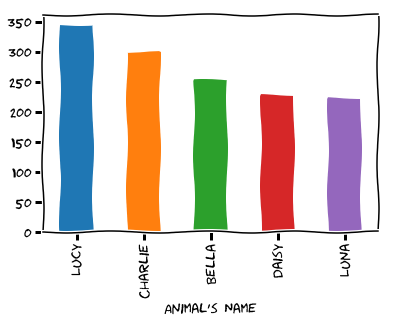

In [9]:
dog_names = dogs.groupby("Animal's Name")["Animal's Name"].count().sort_values(ascending=False)

n_names = 5
top_dog_names = dog_names[:n_names]
with plt.xkcd():
    top_dog_names.plot.bar()
top_dog_names

# This is all fine and dandy, but where can I find the corgis?
(I need more of them in my life)
![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Welchcorgipembroke.JPG/1024px-Welchcorgipembroke.JPG)
Image courtesy of Wikipedia's page on [Welsh Corgis](https://en.wikipedia.org/wiki/Welsh_Corgi)

In [10]:
is_primary_breed_corgi = dogs["Primary Breed"].str.contains("corgi", case=False)
is_secondary_breed_corgi = dogs["Secondary Breed"].str.contains("corgi", case=False)

corgis = dogs[is_primary_breed_corgi | is_secondary_breed_corgi]

In [11]:
corgis

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
18165,November 07 2015,S101423,Midge,Dog,"Welsh Corgi, Pembroke",,98106
18196,November 17 2015,903537,Chelsea,Dog,"Welsh Corgi, Pembroke",,98126
18223,November 23 2015,27139,Teddy,Dog,"Welsh Corgi, Pembroke","Chihuahua, Short Coat",98146
18243,December 01 2015,904550,Ruby,Dog,"Welsh Corgi, Cardigan",Shepherd,98117
18364,February 03 2016,76769,Stella,Dog,Terrier,"Welsh Corgi, Cardigan",98199
18374,February 13 2016,831739,Bella,Dog,"Welsh Corgi, Cardigan",Mix,98118
18578,July 12 2016,444009,Jackie,Dog,Border Collie,"Welsh Corgi, Cardigan",98102
18620,July 14 2016,S101097,Snowball,Dog,"Welsh Corgi, Cardigan",Mix,98126
18651,July 16 2016,440788,Pales,Dog,"Welsh Corgi, Cardigan",,98105
18711,July 20 2016,441748,Laika,Dog,"Dachshund, Standard Smooth Haired","Welsh Corgi, Cardigan",98118


Wait, there are duplicate license numbers in here

In [12]:
corgis[corgis.duplicated(subset=["License Number"])]

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code


At this point, I contacted the dataset owner to make sure they were aware of the fact that duplicate entries exist.

In [15]:
import folium
import requests

SEATTLE_COORDINATES = (47.63, -122.27)
DEFAULT_ZOOM = 10
# Thank you, SeattleIO, for providing this!
ZIPCODE_GEO_URL = (
    "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/zip-codes.geojson"
)
ZIPCODE_GEO_TEXT = requests.get(ZIPCODE_GEO_URL).text

def plot_data_by_zipcode(data,
                         location=SEATTLE_COORDINATES,
                         zoom_start=DEFAULT_ZOOM,
                         geo_data=ZIPCODE_GEO_TEXT, 
                         key_on="feature.properties.ZCTA5CE10",
                         fill_color="PuBuGn",
                         **kwargs):
    """Plot data on a choropleth map
    
    With the exception of map_coordinates and default_zoom, all arguments
    in this function are passed to folium.Map.choropleth. map_coordinates
    and default_zoom arguments are passed in as parameters to the folium.Map
    constructor.
    
    Args:
        data - data to pass into the choropleth map. Corresponds to the
               data argument passed into folium.Map.choropleth and is usually
               a pandas DataFrame or Series.
        **kwargs - Additional arguments to pass to folium.Map.choropleth
        
    Returns:
        A folium.Map instance containing a choropleth of mapped data
    """    
    map_ = folium.Map(location=location, zoom_start=zoom_start)

    map_.choropleth(
        geo_data=geo_data,
        data=data,
        key_on=key_on,
        fill_color=fill_color,
        **kwargs,
    )
    
    return map_

In [16]:
corgi_count_by_zipcode = corgis.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(data=corgi_count_by_zipcode, legend_name="Seattle Corgi Population by Zipcode")

# Is that any different than the distribution of all dogs?

In [17]:
dogs_by_zipcode = dogs.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(dogs_by_zipcode, legend_name="Dog Count by Zipcode")

# Where do the cool cats live?

In [18]:
cats = pets[pets.Species == "Cat"]

cats_by_zipcode = cats.groupby("ZIP Code")["ZIP Code"].count()

plot_data_by_zipcode(data=cats_by_zipcode, legend_name="Cat Count by Zipcode")

# Conclusion - go to Green Lake